## Simulation of Holistic path project in centralized, federated and swarm settings
### Authors: Yazan Ghafir - Alex Bellander
### Supervisors: Mina Alebeigi - Johan Östman

### Imports

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import os
import flwr as fl
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchsummary import summary
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from enum import Enum
from tqdm import tqdm
import gc
from numba import cuda 
import networkx as nx
import random

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

# import the ZOD DevKit
from zod import ZodFrames
from zod import ZodSequences

# import default constants
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject

''' type of ML task. The loss function will be chosen accordingly'''
class TASK(Enum): CLASSIFICATION = 1; REGRESSION = 2;
    
available_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{available_device} is available in this machine using PyTorch {torch.__version__} and Flower {fl.__version__}")
print(f"Pytorch version: {torchvision.__version__}")

cpu is available in this machine using PyTorch 1.12.1 and Flower 1.3.0
Pytorch version: 0.13.1a0


/home/s0001721/anaconda3/envs/zen/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Hyper parameters

In [3]:
# Hyper parameters & Dataset class
NUM_CLIENTS = 2
NUM_OUTPUT = 66
IMG_SIZE = 160
RUN_PRETRAINED = True
ML_TASK = TASK.REGRESSION
BATCH_SIZE=8
VAL_PART=10
SUBSET_RATIO = 0.003
USE_GPU=False
NUM_GLOBAL_ROUNDS = 3
NUM_LOCAL_EPOCHS = 10
PRINT_DEBUG_DATA=True

DEVICE = torch.device('cuda' if USE_GPU else 'cpu')

### Data loading

In [4]:
dataset_root = "/staging/dataset_donation/round_2"
version = "full"  # "mini" or "full"
zod_frames = ZodFrames(dataset_root=dataset_root, version=version)

training_frames_all = zod_frames.get_split(constants.TRAIN)
validation_frames_all = zod_frames.get_split(constants.VAL)

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [5]:
training_frames = training_frames_all[:int(len(training_frames_all) * SUBSET_RATIO)]
validation_frames = validation_frames_all[:int(len(validation_frames_all) * SUBSET_RATIO)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

training_frames length: 269
validation_frames length: 30


In [6]:
class ZodDataset(Dataset):
    def __init__(self, zod_frames, frames_id_set, transform=None, target_transform=None):
        self.zod_frames = zod_frames
        self.frames_id_set = frames_id_set
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frames_id_set)

    def __getitem__(self, idx):
        frame_idx = self.frames_id_set[idx]
        frame = self.zod_frames[frame_idx]
        
        image = frame.get_image(Anonymization.DNAT)
        poses = frame.ego_motion.poses
        x = poses[:,0:1,3]
        y = poses[:,1:2,3]
        z = poses[:,2:3,3]
        coordinates = np.append(x,y)
        coordinates = np.append(coordinates,z)
        
        label = coordinates.astype('float32')
        image = image.astype('float32')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [7]:
def load_datasets(num_clients: int):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE))])

    trainset = ZodDataset(zod_frames=zod_frames, frames_id_set=training_frames, transform=transform)
    testset = ZodDataset(zod_frames=zod_frames, frames_id_set=validation_frames, transform=transform)
    
    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * (num_clients -1)
    lengths.append(len(trainset) - sum(lengths))
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // VAL_PART  
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

### Models

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.is_pretrained=False
        stride = 1
        nr_cv = 2
        # get the dimentions correct
        size_before_fc = IMG_SIZE
        for i in range(0,nr_cv): size_before_fc = (size_before_fc - 2*stride) // 2

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=stride, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=stride, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),
            
            nn.Flatten(),
            nn.Linear(size_before_fc*size_before_fc*64, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, NUM_OUTPUT),
        )

    def forward(self, x):
        return np.squeeze(self.conv(x))

    def model_parameters(self):
        return self.parameters()

class PTNet(nn.Module):
    def __init__(self) -> None:
        super(PTNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.is_pretrained=True

        """freeze parameters and replace head"""
        for param in self.model.parameters():
            param.requires_grad = False
        self.change_head_net()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return np.squeeze(self.model(x))

    def model_parameters(self):
        return self.get_head().parameters()

    def change_head_fc(self):
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, NUM_OUTPUT)

    def change_head_net(self):
        num_ftrs = self.model.fc.in_features
        head_net = nn.Sequential(
            nn.Linear(num_ftrs, 100, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100, NUM_OUTPUT, bias=True),
        )
        self.model.fc = head_net

    def get_head(self):
        return self.model.fc

### Training, evaluation and utilities

In [9]:
def train(net,trainloader, valloader, 
          epochs: int, contin_val=True, plot = True,
          client_cid=None, verbose=0, model_name=""):
    
    """Train the network on the training set."""
    print(f'⇉ Started transfer learning of model {model_name}' if net.is_pretrained else f'Started normal learning of model {model_name}')
    num_batches = len(trainloader)
    print_every = (num_batches // 3) if (num_batches // 3) != 0 else 1
    
    criterion = torch.nn.CrossEntropyLoss() if ML_TASK == TASK.CLASSIFICATION else torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.model_parameters())
    net.train()
    
    losses = []; accs = []; val_losses = []; val_accs = [];
    for epoch in range(epochs):
        correct, total, epoch_acc, epoch_val_accuracy = 0, 0, 0.0, 0.0;
        epoch_loss = []
        for batch_index, (images, labels) in enumerate(trainloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics
            epoch_loss.append(loss.item())
            total += labels.size(0)
            
            if(ML_TASK == TASK.CLASSIFICATION):
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
                
            if batch_index % print_every == 0 and verbose>0:
                print(f"\tBatch {batch_index}/{num_batches}: Train loss: {sum(epoch_loss[-print_every:])/print_every:.3f}, ")
        
        epoch_loss = np.mean(epoch_loss)
        epoch_val_loss, epoch_val_accuracy = test(net, valloader)
        losses.append(epoch_loss); 
        val_losses.append(epoch_val_loss);
        
        if(ML_TASK == TASK.CLASSIFICATION):
            epoch_acc = correct / total
            accs.append(epoch_acc);
            val_accs.append(epoch_val_accuracy);
            
            print(f" ↪ Client{client_cid} Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}, val loss {epoch_val_loss}, accuracy {epoch_val_accuracy}")
        else: 
            print(f" ↪ Client{client_cid} Epoch {epoch+1}: train loss {epoch_loss},\t val loss {epoch_val_loss}")

    if(plot):
      if(ML_TASK == TASK.CLASSIFICATION):
          fig, ax = plt.subplots(ncols=2, figsize=(8,4))
          plot_metrics(ax, [[losses,val_losses],[accs,val_accs]], [f'Corss Entropy Loss - model {model_name}',f'Accuracy - model {model_name}'], ['Number of epochs','Number of epochs'], [['Train', 'Val'],['Train', 'Val']])
      else: 
          fig, ax = plt.subplots(ncols=1, figsize=(8,4))
          plot_metrics([ax], [[losses,val_losses]], [f'RMSE Loss - model {model_name}'], [f'Number of epochs - model {model_name}'], [['Train', 'Val']])
        
    if(client_cid):
        save_model(net, client_cid)
    
    print("For manual plotting:")
    print(f"Client{client_cid} Train losses = {losses}")
    print(f"Client{client_cid} Val_losses = {val_losses}")
    return losses, accs, val_losses, val_accs


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss() if ML_TASK == TASK.CLASSIFICATION else torch.nn.MSELoss()
    correct, total = 0, 0
    net.eval()
    loss = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            outputs = outputs.unsqueeze(0) if outputs.shape[0] != 1 else outputs
            labels = labels.unsqueeze(0) if labels.shape[0] != 1 else labels
            loss.append(criterion(outputs, labels).item())

            if(ML_TASK == TASK.CLASSIFICATION):
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    loss = np.mean(loss)
    accuracy = correct / total if ML_TASK == TASK.CLASSIFICATION else None
    return loss, accuracy


def get_parameters(net) -> List[np.ndarray]:
    if(PRINT_DEBUG_DATA): print("⤺ Get model parameters")
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    if(PRINT_DEBUG_DATA): print("⤻ Set model parameters")
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) if v.shape != torch.Size([]) else torch.Tensor([0]) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def save_model(net, name):
    print(f"🔒 Saved the model of client {name} to the disk. 🔒")
    torch.save(net.state_dict(), f'{name}.pth')

def load_model(name):
    print(f"🛅 Loaded the model of client {name} from the disk. 🛅")
    net = net_instance(f"{name}")
    net = net.load_state_dict(torch.load(f'{name}.pth'))
    add_active_model(net)
    return net

def print_gpu_processes(extra_info=None):
    try:
        if(extra_info):
            print(extra_info, torch.cuda.list_gpu_processes())
        else:
            print(torch.cuda.list_gpu_processes())
    except: pass
    
def clear_gpu():
    print_gpu_processes()
    print("started clearing the GPU RAM.")
    try:
        gc.collect()
        torch.cuda.empty_cache()
    except:
        print("Could not clear the GPU RAM.")
    print_gpu_processes()
    print("Done clearing the GPU RAM.")

def add_active_model(m):
    active_models.append(m)
    
def plot_metrics(axs, metrics, titles, xlabels, legends, ylim=None):
    for i, ax in enumerate(axs):
        for m in metrics[i]:
          ax.plot(m)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.legend(legends[i])
        if ylim:
            ax.set_ylim(ylim)
    
def net_instance(name):
    net = PTNet().to(DEVICE) if RUN_PRETRAINED else Net().to(DEVICE)
    print(f"🌻 Created new model - {name} 🌻")
    return net

def destroy_model(model, name):
    print_gpu_processes(f"⍤ [show gpu process usage before destroying model {name}] ⍤")
    model=model.cpu()
    #odel.destroy()
    del model
    print(f"꧁ destroyed model - {name} ꧂")
    print_gpu_processes(f"⍤ [show gpu process usage after destroying model {name}] ⍤")

def use_cpu(model=None):
    print("swiched to cpu")
    DEVICE = torch.device('cpu')
    if(model):
        model=model.cpu()

def use_gpu():
    print("swiched to gpu")
    DEVICE = torch.device('cuda')

def plot_client_losses(clients_data):
    for client in clients_data:
        fig, ax = plt.subplots(ncols=1, figsize=(8,4))
        plot_metrics([ax], [[client.losses,client.val_losses]], ['RMSE Loss'], ['Number of epochs'], [['Train', 'Val']])

# Centralized Settings

### Hyper parameters

In [ ]:
# Hyper parameters & Dataset class
NUM_CLIENTS = 5
NUM_OUTPUT = 66
IMG_SIZE = 160
RUN_PRETRAINED = True
ML_TASK = TASK.REGRESSION
BATCH_SIZE=8
VAL_PART=10
SUBSET_RATIO = 0.003
USE_GPU=False
NUM_GLOBAL_ROUNDS = 2
NUM_LOCAL_EPOCHS = 6
PRINT_DEBUG_DATA=True

DEVICE = torch.device('cuda' if USE_GPU else 'cpu')

In [ ]:
training_frames = training_frames_all[:int(len(training_frames_all) * SUBSET_RATIO)]
validation_frames = validation_frames_all[:int(len(validation_frames_all) * SUBSET_RATIO)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

training_frames length: 269
validation_frames length: 30


In [ ]:
trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

GPU:0
no processes are running
started clearing the GPU RAM.
GPU:0
no processes are running
Done clearing the GPU RAM.
🌻 Created new model - Centralized 🌻
nr of training imgs: 121
nr of validation imgs: 13
nr of test imgs: 30
input shape: torch.Size([3, 160, 160])
output shape: (66,)
training on cpu
⇉ Started transfer learning of model Centralized


/home/s0001721/anaconda3/envs/zen/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 66])) that is different to the input size (torch.Size([66])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 ↪ ClientNone Epoch 1: train loss 1652.0017204284668,	 val loss 2061.3154296875
 ↪ ClientNone Epoch 2: train loss 1036.9758615493774,	 val loss 863.8117370605469
 ↪ ClientNone Epoch 3: train loss 686.5182523727417,	 val loss 741.528076171875
 ↪ ClientNone Epoch 4: train loss 599.2919626235962,	 val loss 820.8211669921875
 ↪ ClientNone Epoch 5: train loss 534.4438186883926,	 val loss 655.2718200683594
 ↪ ClientNone Epoch 6: train loss 532.6898231506348,	 val loss 666.30908203125
 ↪ ClientNone Epoch 7: train loss 509.09375381469727,	 val loss 630.7112731933594
 ↪ ClientNone Epoch 8: train loss 440.7629249095917,	 val loss 556.47412109375
 ↪ ClientNone Epoch 9: train loss 401.99180912971497,	 val loss 499.12355041503906
 ↪ ClientNone Epoch 10: train loss 392.43972063064575,	 val loss 490.9909362792969
For manual plotting:
ClientNone Train losses = [1652.0017204284668, 1036.9758615493774, 686.5182523727417, 599.2919626235962, 534.4438186883926, 532.6898231506348, 509.09375381469727, 440.76

(432.1087112426758, 2, {'accuracy': None})

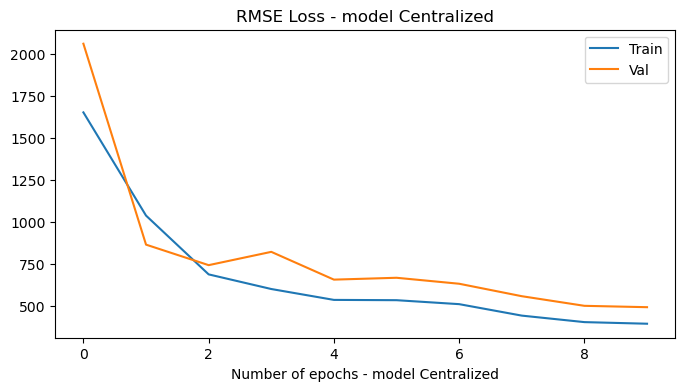

*** SIGTERM received at time=1676272012 on cpu 0 ***
PC: @     0x7fcb61d1746e  (unknown)  epoll_wait
    @     0x7fcb61f58420  (unknown)  (unknown)
[2023-02-13 08:06:52,057 E 2172628 2172628] logging.cc:361: *** SIGTERM received at time=1676272012 on cpu 0 ***
[2023-02-13 08:06:52,057 E 2172628 2172628] logging.cc:361: PC: @     0x7fcb61d1746e  (unknown)  epoll_wait
[2023-02-13 08:06:52,057 E 2172628 2172628] logging.cc:361:     @     0x7fcb61f58420  (unknown)  (unknown)


In [ ]:
def run_centralized(print_summery=False):
    # clear gpu
    clear_gpu()
    
    # create the net
    net = net_instance("Centralized")
    
    # data
    trainloader = trainloaders[0]
    valloader = valloaders[0]
    
    # summery
    print('nr of training imgs:', len(trainloader.dataset))
    print('nr of validation imgs:', len(valloader.dataset))
    print('nr of test imgs:', len(testloader.dataset))
    print('input shape:', trainloader.dataset[0][0].shape)
    print('output shape:', trainloader.dataset[0][1].shape)
    print(f'training on {DEVICE}')
    if(print_summery): print(summary(net, input_shape))
        
    # train & val
    train_losses, train_accs, val_losses, val_accs = train(
        net, 
        trainloader, 
        valloader, 
        epochs=NUM_LOCAL_EPOCHS,
        contin_val=True, 
        plot=True,
        verbose=0, 
        model_name=f"Centralized"
        )
    loss, accuracy = test(net, testloader)
    if(ML_TASK == TASK.CLASSIFICATION): print(f"►►► test loss {loss}, accuracy {accuracy}")
    else: print(f"►►► test RMSE {loss}")
        
    return float(loss), len(valloader), {"accuracy": float(accuracy) if accuracy else None}

run_centralized(print_summery=False)

# Federated Settings


### Flower client

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.losses=[]
        self.val_losses=[]

    def get_parameters(self, config):
        print(f"⤺ Get model parameters of client {self.cid}]")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"○ started local training of client {self.cid}]")
        set_parameters(self.net, parameters)
        losses, accs, val_losses, val_accs=train(
            self.net, 
            self.trainloader, 
            self.valloader, 
            epochs=NUM_LOCAL_EPOCHS,
            contin_val=True, 
            plot=True,
            verbose=0, 
            client_cid=self.cid,
            model_name=f"client {self.cid}"
        )
        self.losses.append(losses)
        self.val_losses.append(val_losses)
        params = get_parameters(self.net)
        save_model(self.net, self.cid)
        return params, len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        if(not self.net):
            self.net = load_model(self.cid)
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        if(ML_TASK == TASK.CLASSIFICATION): 
            print(f"🌠 [Client {self.cid}] test loss {loss}, accuracy {accuracy}")
            return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
        else: 
            print(f"🌠 [Client {self.cid}] test RMSE {loss}")
            return float(loss), len(self.valloader), {"loss": float(loss)}


def client_fn(cid) -> FlowerClient:
    net = net_instance(f"client {cid}")
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    client=FlowerClient(cid, net, trainloader, valloader)
    return client

Let's test what we have so far before we continue:

In [ ]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
  client_resources = {"num_gpus": 1}

# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = net_instance(f"server")
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    save_model(net, "server")
    if(ML_TASK == TASK.CLASSIFICATION): 
        print(f"Server-side evaluation loss {float(loss)} / accuracy {float(accuracy)}")
        destroy_model(net, "server")
        return float(loss), {"accuracy": float(accuracy)}
    else: 
        print(f"Server-side evaluation loss {float(loss)}")
        destroy_model(net, "server")
        return float(loss), {}

# Pass parameters to the Strategy for server-side parameter initialization
server_model = net_instance(f"server")
server_params = get_parameters(server_model)
#destroy_model(server_model, "server")
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(server_params),
    evaluate_fn=evaluate
)
    
# start federated learning simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_GLOBAL_ROUNDS),
    client_resources=client_resources,
    strategy=strategy,
)

INFO flwr 2023-02-13 01:10:00,885 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)


🌻 Created new model - server 🌻
⤺ Get model parameters


2023-02-13 01:10:03,226	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-02-13 01:10:03,998 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 14153792718.0, 'node:192.168.0.46': 1.0, 'accelerator_type:P2000': 1.0, 'CPU': 12.0, 'object_store_memory': 7076896358.0, 'GPU': 1.0}
INFO flwr 2023-02-13 01:10:03,999 | server.py:86 | Initializing global parameters
INFO flwr 2023-02-13 01:10:03,999 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 2023-02-13 01:10:03,999 | server.py:88 | Evaluating initial parameters


🌻 Created new model - server 🌻
⤻ Set model parameters


INFO flwr 2023-02-13 01:10:06,889 | server.py:91 | initial parameters (loss, other metrics): 2393.1879272460938, {}
INFO flwr 2023-02-13 01:10:06,890 | server.py:101 | FL starting
DEBUG flwr 2023-02-13 01:10:06,891 | server.py:215 | fit_round 1: strategy sampled 2 clients (out of 2)


🔒 Saved the model of client server to the disk. 🔒
Server-side evaluation loss 2393.1879272460938
⍤ [show gpu process usage before destroying model server] ⍤ GPU:0
no processes are running
꧁ destroyed model - server ꧂
⍤ [show gpu process usage after destroying model server] ⍤ GPU:0
no processes are running
(launch_and_fit pid=2173007) 🌻 Created new model - client 1 🌻
(launch_and_fit pid=2173007) ○ started local training of client 1]
(launch_and_fit pid=2173007) ⤻ Set model parameters
(launch_and_fit pid=2173007) ⇉ Started transfer learning of model client 1
(launch_and_fit pid=2172999) 🌻 Created new model - client 0 🌻
(launch_and_fit pid=2172999) ○ started local training of client 0]
(launch_and_fit pid=2172999) ⤻ Set model parameters
(launch_and_fit pid=2172999) ⇉ Started transfer learning of model client 0


(launch_and_fit pid=2172999) /home/s0001721/anaconda3/envs/zen/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 66])) that is different to the input size (torch.Size([66])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(launch_and_fit pid=2172999)   return F.mse_loss(input, target, reduction=self.reduction)


(launch_and_fit pid=2173007)  ↪ Client1 Epoch 1: train loss 1608.9012336730957,	 val loss 1401.1082153320312
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 1: train loss 1690.6444549560547,	 val loss 1956.8177490234375
(launch_and_fit pid=2173007)  ↪ Client1 Epoch 2: train loss 832.783745765686,	 val loss 616.7889404296875
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 2: train loss 1014.9412422180176,	 val loss 823.3482666015625
(launch_and_fit pid=2173007)  ↪ Client1 Epoch 3: train loss 635.5203704833984,	 val loss 579.5692901611328
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 3: train loss 614.5361881256104,	 val loss 803.9219360351562
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 4: train loss 612.3685903549194,	 val loss 743.2051086425781
(launch_and_fit pid=2173007)  ↪ Client1 Epoch 4: train loss 558.8975772857666,	 val loss 546.1353607177734
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 5: train loss 610.2107501029968,	 val loss 714.6019287109375
(launch_and_fit pid=2173007)  ↪ C

DEBUG flwr 2023-02-13 01:15:30,987 | server.py:229 | fit_round 1 received 2 results and 0 failures


(launch_and_fit pid=2173007) 🔒 Saved the model of client 1 to the disk. 🔒
(launch_and_fit pid=2173007) For manual plotting:
(launch_and_fit pid=2173007) Client1 Train losses = [1608.9012336730957, 832.783745765686, 635.5203704833984, 558.8975772857666, 542.4425792694092, 494.491247177124, 441.5395040512085, 390.25145626068115, 338.12886476516724, 295.681458234787]
(launch_and_fit pid=2173007) Client1 Val_losses = [1401.1082153320312, 616.7889404296875, 579.5692901611328, 546.1353607177734, 517.1003112792969, 504.98468017578125, 454.2438507080078, 417.70489501953125, 372.22084045410156, 331.12831115722656]
(launch_and_fit pid=2173007) ⤺ Get model parameters
(launch_and_fit pid=2173007) 🔒 Saved the model of client 1 to the disk. 🔒


WARNING flwr 2023-02-13 01:15:31,080 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


🌻 Created new model - server 🌻
⤻ Set model parameters


INFO flwr 2023-02-13 01:15:33,054 | server.py:116 | fit progress: (1, 529.5398559570312, {}, 326.1632797389757)
DEBUG flwr 2023-02-13 01:15:33,055 | server.py:165 | evaluate_round 1: strategy sampled 2 clients (out of 2)


🔒 Saved the model of client server to the disk. 🔒
Server-side evaluation loss 529.5398559570312
⍤ [show gpu process usage before destroying model server] ⍤ GPU:0
no processes are running
꧁ destroyed model - server ꧂
⍤ [show gpu process usage after destroying model server] ⍤ GPU:0
no processes are running
(launch_and_evaluate pid=2173007) 🌻 Created new model - client 1 🌻
(launch_and_evaluate pid=2173007) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=2173007) ⤻ Set model parameters
(launch_and_evaluate pid=2172999) 🌻 Created new model - client 0 🌻
(launch_and_evaluate pid=2172999) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=2172999) ⤻ Set model parameters


DEBUG flwr 2023-02-13 01:16:14,040 | server.py:179 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-02-13 01:16:14,040 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-02-13 01:16:14,041 | server.py:215 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2173007) 🌠 [Client 1] test RMSE 344.38194274902344
(launch_and_evaluate pid=2172999) 🌠 [Client 0] test RMSE 529.5398559570312
(launch_and_fit pid=2172999) 🌻 Created new model - client 0 🌻
(launch_and_fit pid=2172999) ○ started local training of client 0]
(launch_and_fit pid=2172999) ⤻ Set model parameters
(launch_and_fit pid=2172999) ⇉ Started transfer learning of model client 0
(launch_and_fit pid=2173007) 🌻 Created new model - client 1 🌻
(launch_and_fit pid=2173007) ○ started local training of client 1]
(launch_and_fit pid=2173007) ⤻ Set model parameters
(launch_and_fit pid=2173007) ⇉ Started transfer learning of model client 1


(launch_and_fit pid=2172999) /home/s0001721/anaconda3/envs/zen/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 66])) that is different to the input size (torch.Size([66])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(launch_and_fit pid=2172999)   return F.mse_loss(input, target, reduction=self.reduction)


(launch_and_fit pid=2173007)  ↪ Client1 Epoch 1: train loss 390.3576135635376,	 val loss 292.5580139160156
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 1: train loss 459.2381544113159,	 val loss 492.74847412109375
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 2: train loss 413.96454524993896,	 val loss 480.87171936035156
(launch_and_fit pid=2173007)  ↪ Client1 Epoch 2: train loss 347.2245919704437,	 val loss 255.0896759033203
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 3: train loss 305.19247379899025,	 val loss 401.6163024902344
(launch_and_fit pid=2173007)  ↪ Client1 Epoch 3: train loss 283.3514642715454,	 val loss 220.3334197998047
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 4: train loss 279.4563263654709,	 val loss 383.29212188720703
(launch_and_fit pid=2173007)  ↪ Client1 Epoch 4: train loss 245.8476700782776,	 val loss 188.06958770751953
(launch_and_fit pid=2172999)  ↪ Client0 Epoch 5: train loss 281.7036335468292,	 val loss 388.7433853149414
(launch_and_fit pid=2173007)  ↪

DEBUG flwr 2023-02-13 01:22:01,598 | server.py:229 | fit_round 2 received 2 results and 0 failures


(launch_and_fit pid=2173007)  ↪ Client1 Epoch 10: train loss 150.0322244167328,	 val loss 104.29448699951172
(launch_and_fit pid=2173007) 🔒 Saved the model of client 1 to the disk. 🔒
(launch_and_fit pid=2173007) For manual plotting:
(launch_and_fit pid=2173007) Client1 Train losses = [390.3576135635376, 347.2245919704437, 283.3514642715454, 245.8476700782776, 227.1838402748108, 202.16422986984253, 184.79159200191498, 158.71484890580177, 158.30909156799316, 150.0322244167328]
(launch_and_fit pid=2173007) Client1 Val_losses = [292.5580139160156, 255.0896759033203, 220.3334197998047, 188.06958770751953, 160.27408599853516, 155.34737396240234, 128.6970329284668, 155.59046936035156, 121.18611526489258, 104.29448699951172]
(launch_and_fit pid=2173007) ⤺ Get model parameters
(launch_and_fit pid=2173007) 🔒 Saved the model of client 1 to the disk. 🔒
🌻 Created new model - server 🌻
⤻ Set model parameters


INFO flwr 2023-02-13 01:22:03,370 | server.py:116 | fit progress: (2, 337.81494140625, {}, 716.479224620969)
DEBUG flwr 2023-02-13 01:22:03,372 | server.py:165 | evaluate_round 2: strategy sampled 2 clients (out of 2)


🔒 Saved the model of client server to the disk. 🔒
Server-side evaluation loss 337.81494140625
⍤ [show gpu process usage before destroying model server] ⍤ GPU:0
no processes are running
꧁ destroyed model - server ꧂
⍤ [show gpu process usage after destroying model server] ⍤ GPU:0
no processes are running
(launch_and_evaluate pid=2173007) 🌻 Created new model - client 0 🌻
(launch_and_evaluate pid=2173007) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=2173007) ⤻ Set model parameters
(launch_and_evaluate pid=2172999) 🌻 Created new model - client 1 🌻
(launch_and_evaluate pid=2172999) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=2172999) ⤻ Set model parameters


DEBUG flwr 2023-02-13 01:22:45,632 | server.py:179 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-02-13 01:22:45,632 | server.py:215 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2173007) 🌠 [Client 0] test RMSE 337.81494140625
(launch_and_evaluate pid=2172999) 🌠 [Client 1] test RMSE 105.0139045715332
(launch_and_fit pid=2172999) 🌻 Created new model - client 1 🌻
(launch_and_fit pid=2172999) ○ started local training of client 1]
(launch_and_fit pid=2172999) ⤻ Set model parameters
(launch_and_fit pid=2172999) ⇉ Started transfer learning of model client 1
(launch_and_fit pid=2173007) 🌻 Created new model - client 0 🌻
(launch_and_fit pid=2173007) ○ started local training of client 0]
(launch_and_fit pid=2173007) ⤻ Set model parameters
(launch_and_fit pid=2173007) ⇉ Started transfer learning of model client 0


(launch_and_fit pid=2173007) /home/s0001721/anaconda3/envs/zen/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 66])) that is different to the input size (torch.Size([66])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(launch_and_fit pid=2173007)   return F.mse_loss(input, target, reduction=self.reduction)


(launch_and_fit pid=2172999)  ↪ Client1 Epoch 1: train loss 233.40780544281006,	 val loss 104.17168426513672
(launch_and_fit pid=2173007)  ↪ Client0 Epoch 1: train loss 260.98281031847,	 val loss 333.2372283935547
(launch_and_fit pid=2173007)  ↪ Client0 Epoch 2: train loss 207.58581686019897,	 val loss 341.51141357421875
(launch_and_fit pid=2172999)  ↪ Client1 Epoch 2: train loss 176.01732110977173,	 val loss 111.6244010925293
(launch_and_fit pid=2173007)  ↪ Client0 Epoch 3: train loss 201.43907713890076,	 val loss 331.3164825439453
(launch_and_fit pid=2172999)  ↪ Client1 Epoch 3: train loss 174.19616836309433,	 val loss 133.54224395751953
(launch_and_fit pid=2173007)  ↪ Client0 Epoch 4: train loss 176.82288479804993,	 val loss 344.19940185546875
(launch_and_fit pid=2172999)  ↪ Client1 Epoch 4: train loss 200.0009982585907,	 val loss 89.03774642944336
(launch_and_fit pid=2173007)  ↪ Client0 Epoch 5: train loss 165.8528608083725,	 val loss 350.93299865722656
(launch_and_fit pid=2172999)

DEBUG flwr 2023-02-13 01:28:41,487 | server.py:229 | fit_round 3 received 2 results and 0 failures


(launch_and_fit pid=2172999)  ↪ Client1 Epoch 10: train loss 96.71796202659607,	 val loss 84.2118034362793
(launch_and_fit pid=2172999) 🔒 Saved the model of client 1 to the disk. 🔒
(launch_and_fit pid=2172999) For manual plotting:
(launch_and_fit pid=2172999) Client1 Train losses = [233.40780544281006, 176.01732110977173, 174.19616836309433, 200.0009982585907, 175.63171339035034, 134.08139657974243, 120.91605854034424, 109.85782027244568, 104.36679601669312, 96.71796202659607]
(launch_and_fit pid=2172999) Client1 Val_losses = [104.17168426513672, 111.6244010925293, 133.54224395751953, 89.03774642944336, 99.3854751586914, 92.85617446899414, 85.16909790039062, 89.86140060424805, 86.51518630981445, 84.2118034362793]
(launch_and_fit pid=2172999) ⤺ Get model parameters
(launch_and_fit pid=2172999) 🔒 Saved the model of client 1 to the disk. 🔒
🌻 Created new model - server 🌻
⤻ Set model parameters


INFO flwr 2023-02-13 01:28:43,055 | server.py:116 | fit progress: (3, 318.47715759277344, {}, 1116.1642911279923)
DEBUG flwr 2023-02-13 01:28:43,057 | server.py:165 | evaluate_round 3: strategy sampled 2 clients (out of 2)


🔒 Saved the model of client server to the disk. 🔒
Server-side evaluation loss 318.47715759277344
⍤ [show gpu process usage before destroying model server] ⍤ GPU:0
no processes are running
꧁ destroyed model - server ꧂
⍤ [show gpu process usage after destroying model server] ⍤ GPU:0
no processes are running
(launch_and_evaluate pid=2172999) 🌻 Created new model - client 0 🌻
(launch_and_evaluate pid=2172999) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=2172999) ⤻ Set model parameters
(launch_and_evaluate pid=2173007) 🌻 Created new model - client 1 🌻
(launch_and_evaluate pid=2173007) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=2173007) ⤻ Set model parameters
(launch_and_evaluate pid=2172999) 🌠 [Client 0] test RMSE 318.47715759277344


DEBUG flwr 2023-02-13 01:29:27,640 | server.py:179 | evaluate_round 3 received 2 results and 0 failures
INFO flwr 2023-02-13 01:29:27,641 | server.py:144 | FL finished in 1160.749912323954
INFO flwr 2023-02-13 01:29:27,642 | app.py:202 | app_fit: losses_distributed [(1, 436.96089935302734), (2, 221.4144229888916), (3, 204.21450805664062)]
INFO flwr 2023-02-13 01:29:27,642 | app.py:203 | app_fit: metrics_distributed {}
INFO flwr 2023-02-13 01:29:27,643 | app.py:204 | app_fit: losses_centralized [(0, 2393.1879272460938), (1, 529.5398559570312), (2, 337.81494140625), (3, 318.47715759277344)]
INFO flwr 2023-02-13 01:29:27,643 | app.py:205 | app_fit: metrics_centralized {}


History (loss, distributed):
	round 1: 436.96089935302734
	round 2: 221.4144229888916
	round 3: 204.21450805664062
History (loss, centralized):
	round 0: 2393.1879272460938
	round 1: 529.5398559570312
	round 2: 337.81494140625
	round 3: 318.47715759277344

(launch_and_evaluate pid=2173007) 🌠 [Client 1] test RMSE 89.95185852050781


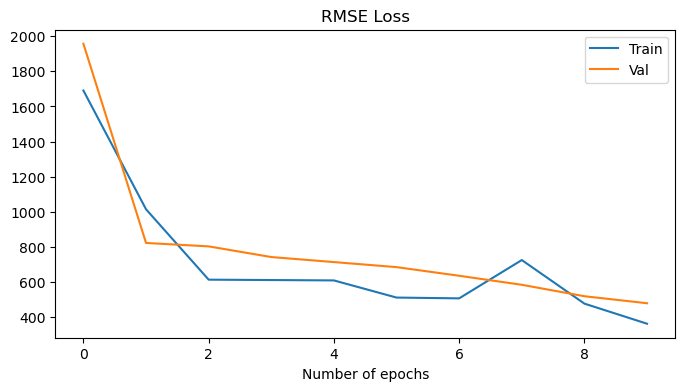

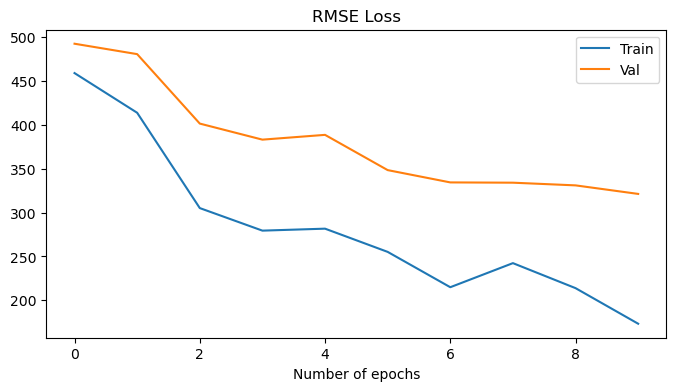

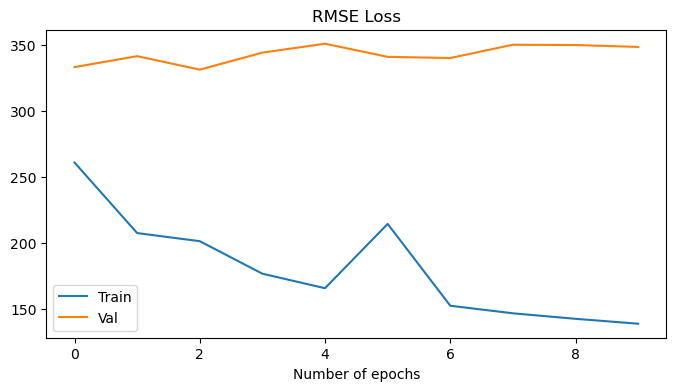

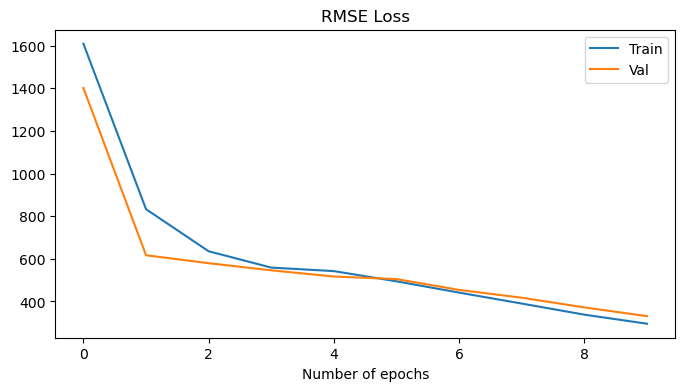

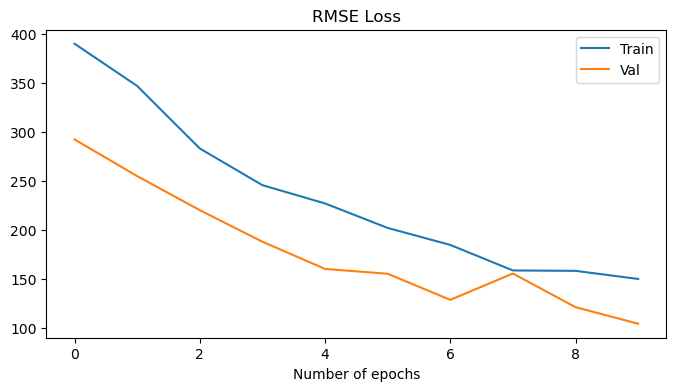

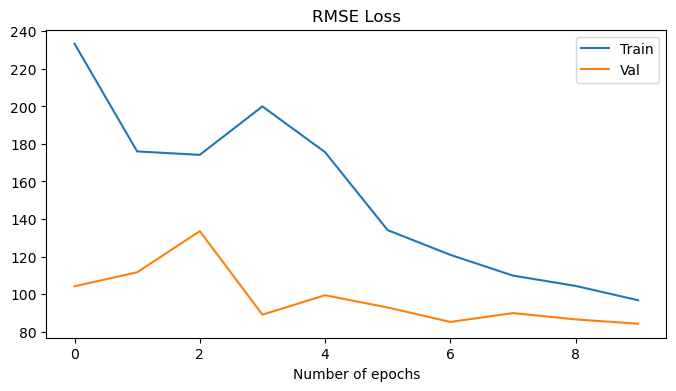

In [ ]:
"""Copy past the reported lists of losses in the output. 
We must unfortunatly do so because flower neither support 
plots in their ouputs nor support for shared global variables.
Each flower client run on its own thread with no critical section
in a thread safe manner. Improvement could be to start a flask server
locally and let all clients report their losses to it"""

c_0_g_1_losses = [1690.6444549560547, 1014.9412422180176, 614.5361881256104, 612.3685903549194, 610.2107501029968, 512.6537094116211, 508.1816186904907, 726.1283893585205, 478.2240810394287, 363.8907632827759]
c_0_g_1_val_losses = [1956.8177490234375, 823.3482666015625, 803.9219360351562, 743.2051086425781, 714.6019287109375, 685.8788146972656, 636.6861877441406, 585.3804016113281, 520.2999877929688, 480.45567321777344]
c_1_g_1_losses = [1608.9012336730957, 832.783745765686, 635.5203704833984, 558.8975772857666, 542.4425792694092, 494.491247177124, 441.5395040512085, 390.25145626068115, 338.12886476516724, 295.681458234787]
c_1_g_1_val_losses = [1401.1082153320312, 616.7889404296875, 579.5692901611328, 546.1353607177734, 517.1003112792969, 504.98468017578125, 454.2438507080078, 417.70489501953125, 372.22084045410156, 331.12831115722656]

c_0_g_2_losses = [459.2381544113159, 413.96454524993896, 305.19247379899025, 279.4563263654709, 281.7036335468292, 255.21258783340454, 214.88861274719238, 242.37042951583862, 213.8360414505005, 173.2316736280918]
c_0_g_2_val_losses = [492.74847412109375, 480.87171936035156, 401.6163024902344, 383.29212188720703, 388.7433853149414, 348.52921295166016, 334.4865493774414, 334.1679153442383, 331.102783203125, 321.3601989746094]
c_1_g_2_losses = [390.3576135635376, 347.2245919704437, 283.3514642715454, 245.8476700782776, 227.1838402748108, 202.16422986984253, 184.79159200191498, 158.71484890580177, 158.30909156799316, 150.0322244167328]
c_1_g_2_val_losses = [292.5580139160156, 255.0896759033203, 220.3334197998047, 188.06958770751953, 160.27408599853516, 155.34737396240234, 128.6970329284668, 155.59046936035156, 121.18611526489258, 104.29448699951172]

c_0_g_3_losses = [260.98281031847, 207.58581686019897, 201.43907713890076, 176.82288479804993, 165.8528608083725, 214.53673338890076, 152.57782626152039, 146.84755206108093, 142.67551338672638, 138.9631040096283]
c_0_g_3_val_losses = [333.2372283935547, 341.51141357421875, 331.3164825439453, 344.19940185546875, 350.93299865722656, 340.9968719482422, 340.11328125, 350.1651306152344, 349.9345703125, 348.4996795654297]
c_1_g_3_losses = [233.40780544281006, 176.01732110977173, 174.19616836309433, 200.0009982585907, 175.63171339035034, 134.08139657974243, 120.91605854034424, 109.85782027244568, 104.36679601669312, 96.71796202659607]
c_1_g_3_val_losses = [104.17168426513672, 111.6244010925293, 133.54224395751953, 89.03774642944336, 99.3854751586914, 92.85617446899414, 85.16909790039062, 89.86140060424805, 86.51518630981445, 84.2118034362793]

c0_g1 = type('',(object,),{"losses": c_0_g_1_losses, "val_losses":c_0_g_1_val_losses})()
c0_g2 = type('',(object,),{"losses": c_0_g_2_losses, "val_losses":c_0_g_2_val_losses})()
c0_g3 = type('',(object,),{"losses": c_0_g_3_losses, "val_losses":c_0_g_3_val_losses})()
c1_g1 = type('',(object,),{"losses": c_1_g_1_losses, "val_losses":c_1_g_1_val_losses})()
c1_g2 = type('',(object,),{"losses": c_1_g_2_losses, "val_losses":c_1_g_2_val_losses})()
c1_g3 = type('',(object,),{"losses": c_1_g_3_losses, "val_losses":c_1_g_3_val_losses})()


plot_client_losses([c0_g1,c0_g2,c0_g3,c1_g1,c1_g2,c1_g3])

# Swarm Settings

### Hyper parameters

In [10]:
# Hyper parameters & Dataset class
NUM_CLIENTS = 5
NUM_OUTPUT = 66
IMG_SIZE = 160
RUN_PRETRAINED = True
ML_TASK = TASK.REGRESSION
BATCH_SIZE=8
VAL_PART=10
SUBSET_RATIO = 0.003
USE_GPU=False
NUM_GLOBAL_ROUNDS = 2
NUM_LOCAL_EPOCHS = 6
PRINT_DEBUG_DATA=True

DEVICE = torch.device('cuda' if USE_GPU else 'cpu')

In [11]:
training_frames = training_frames_all[:int(len(training_frames_all) * SUBSET_RATIO)]
validation_frames = validation_frames_all[:int(len(validation_frames_all) * SUBSET_RATIO)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

training_frames length: 269
validation_frames length: 30


In [12]:
trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

### Client

In [13]:
class Client():
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.losses=[]
        self.val_losses=[]

    def get_parameters(self):
        print(f"⤺ Get model parameters of client {self.cid}]")
        return self.net.state_dict()

    def fit(self, round_info):
        print(f"○ started local training of client {self.cid}] - {round_info}")
        losses, accs, val_losses, val_accs=train(
            self.net, 
            self.trainloader, 
            self.valloader, 
            epochs=NUM_LOCAL_EPOCHS,
            contin_val=True, 
            plot=True,
            verbose=0, 
            client_cid=self.cid,
            model_name=f"client {self.cid} - {round_info}"
        )
            
        self.losses.append(losses)
        self.val_losses.append(val_losses)
    
    def aggregate(self, model_params, strategy=None):
        if(not strategy):
            self.FedAvg(model_params)

    def FedAvg(self, model_params):
        averaged_weights = OrderedDict()
        self_params = self.net.state_dict()
        
        for key in self_params.keys():
            averaged_weights[key] = (self_params[key] + model_params[key]) /2
            
        self.net.load_state_dict(averaged_weights)
        
    def validate(self):
        loss, accuracy = test(self.net, self.valloader)
        if(ML_TASK == TASK.CLASSIFICATION): 
            print(f"🌠 [Client {self.cid}] test loss {loss}, accuracy {accuracy}")
            return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
        else: 
            print(f"🌠 [Client {self.cid}] test RMSE {loss}")
            return float(loss), len(self.valloader), {"loss": float(loss)}

### Swarm simulator

In [14]:
def create_client(cid):
    net = net_instance(f"client {cid}")
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    client=Client(cid, net, trainloader, valloader)
    return client

def aggregate_share(client_1, client_2):
    """send model parameters between 2 clients, aggregate 
    them and set them into the network of each of them"""
    print(f"-> Validating before aggregating:")
    client_1.validate()
    client_2.validate()
    client_1_params = client_1.get_parameters()
    client_2_params = client_2.get_parameters()
    client_1.aggregate(client_2_params)
    client_2.aggregate(client_1_params)
    print(f"⦿ Aggredated parameter of {client_1.cid} and {client_2.cid} and shared the aggregated model to both")
    print(f"<- Validating After aggregating:")
    client_1.validate()
    client_2.validate()
    
def perform_global_round(clients_network, round_number, client_cids=None):
    print(f"⦿ Started global round {round_number} between the clients {client_cids if client_cids else [c.cid for c in clients_network]}")
    if(client_cids):
        for c_idx in client_cids:
            clients_network[c_idx].fit(round_info=f"global round {round_number}")
    else:
        for c in clients_network:
            c.fit(round_info=f"global round {round_number}")
    print("⦿ End global round")
            
def create_fully_connected_graph(clients_network):
    nodes=[]; edges=[];
    for i in range(len(clients_network)):
        nodes.append(i)
        for j in range(i+1,len(clients_network)):
            edges.append((i,j))
    return nodes, edges

def aggregate_clients(clients_network,edges):
    print("⦿ Started Aggregation")
    for c_1_idx, c_2_idx in edges:
        aggregate_share(clients_network[c_1_idx], clients_network[c_2_idx])
    
def simulate_fully_connected_graph(clients_network):
    nodes, edges = create_fully_connected_graph(clients_network)
    
    for i in range(NUM_GLOBAL_ROUNDS):
        # perform one global rounds on all
        perform_global_round(clients_network, round_number=i)

        # share and aggregate weights between all clients
        aggregate_clients(clients_network,edges)   
        
    return nodes, edges

def simulate_random_dynamic_graph(clients_network):
    nodes = []
    edges = []
    for i in range(NUM_GLOBAL_ROUNDS):
        
        random_edges = [get_random_edge(clients_network) for _ in range(3)]
        nodes_of_edges = get_nodes_from_edges(random_edges)
        perform_global_round(clients_network, client_cids=nodes_of_edges, round_number=i)
        
        edges.extend(random_edges)
        nodes.extend(nodes_of_edges)
        
        # share and aggregate weights between  clients
        aggregate_clients(clients_network,random_edges)   
        
    return nodes, edges

def get_network_nodes(clients_network):
    return [c.cid for c in clients_network]

def get_nodes_from_edges(edges):
    return set([item for t in edges for item in t])

def get_random_edge(clients_network):
    c_1_cid = random.choice(clients_network).cid
    c_2_cid = random.choice(clients_network).cid
    while(c_1_cid == c_2_cid):
        c_2_cid = random.choice(clients_network).cid
    return (c_1_cid,c_2_cid)

def plot_typology_graph(nodes, edges):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw_networkx(G, bbox = dict(facecolor = "skyblue",
                 boxstyle = "round", ec = "silver", pad = 1),
                 edge_color = "gray")
    plt.title("Swarm learning simulation graph")
    plt.show()

### Simulation of swarm learning

In [15]:
# create and add clients
clients_network = [create_client(i) for i in range(NUM_CLIENTS)]

# swarm simulation - fully connected graph
nodes, edges = simulate_fully_connected_graph(clients_network)

🌻 Created new model - client 0 🌻
🌻 Created new model - client 1 🌻
🌻 Created new model - client 2 🌻
🌻 Created new model - client 3 🌻
🌻 Created new model - client 4 🌻
⦿ Started global round 0 between the clients [0, 1, 2, 3, 4]
○ started local training of client 0] - global round 0
⇉ Started transfer learning of model client 0 - global round 0
 ↪ Client0 Epoch 1: train loss 2191.8597412109375,	 val loss 2572.12548828125
 ↪ Client0 Epoch 2: train loss 2138.866485595703,	 val loss 2477.602294921875
 ↪ Client0 Epoch 3: train loss 2010.1343587239583,	 val loss 2261.297607421875
 ↪ Client0 Epoch 4: train loss 1739.9141133626301,	 val loss 1867.2047119140625


KeyboardInterrupt: 

In [ ]:
plot_typology_graph(nodes, edges)

In [ ]:
# create and add clients
clients_network = [create_client(i) for i in range(NUM_CLIENTS)]

# swarm simulation - dynamic graph
nodes, edges = simulate_random_dynamic_graph(clients_network)

In [ ]:
plot_typology_graph(nodes, edges)